# Import Libs & Datasets

In [1]:
# Import Libs
import dowhy, os
import dowhy.datasets
import pandas as pd
import numpy as np
import graphviz
from graphviz import *
import matplotlib.pyplot as plt
import seaborn as sns
from dowhy import *
sns.set()
%matplotlib inline

https://www.kaggle.com/kabure/german-credit-data-with-risk

# Data Preprocess

- If the applicant is a good credit risk, i.e. is likely to repay the loan, then not approving the loan to the person results in a loss of business to the bank
- If the applicant is a bad credit risk, i.e. is not likely to repay the loan, then approving the loan to the person results in a financial loss to the bank

In [2]:
data = pd.read_csv('./dataset/german/german_credit.csv', index_col=0)
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [3]:
for i in range(len(data.index)):
    if data['Risk'][i] == 'good':
        data['Risk'][i] = 1
    else:
        data['Risk'][i] = 0
data['Risk'].unique()

array([1, 0], dtype=object)

https://www.kaggle.com/kabure/predicting-credit-risk-model-pipeline

In [4]:
print('data shape  |', data.shape)

data shape  | (1000, 10)


In [5]:
print(data.info())
#Looking unique values
print(data.nunique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 125.9+ KB
None
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64


# Define Functions

In [6]:
# https://graphviz.readthedocs.io/en/stable/examples.html#process-py
def graphviz(t_, o_, cc_, ate, latent = True):
    g = Digraph('finite_state_machine', filename = f'{t_}_on_{o_}.gv')
    g.attr(size='8,8')

    g.attr('node', shape = 'Msquare', color = 'black')
    g.node(t_)
    g.node(o_)

    g.attr('node', shape = 'circle', color = 'black')
    for cc in cc_:
        g.edge(cc, t_)
        g.edge(cc, o_)
    
    g.edge(t_, o_, label = str(ate))

    if latent:
        g.attr('node', shape = 'circle', style = 'filled', color = 'black')
        g.edge('U', t_, color = 'lightgrey')
        g.edge('U', o_, color = 'lightgrey')
    
    return g  

In [7]:
def cm(data, t_, o_, cc_):
    model=CausalModel(
            data = data,
            treatment= t_,
            outcome= o_,
            common_causes= cc_)

    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    estimate = model.estimate_effect(identified_estimand,
            method_name="backdoor.propensity_score_weighting",
            method_params={"weighting_scheme":"ips_weight"})
    return estimate.value

In [8]:
def analysis(data, t_, o_, cc_):
    score_ = cm(data, t_, o_, cc_)
    graphviz_ = graphviz(t_, o_, cc_, score_)
    print(f'ATE of Treatment \'{t_}\' on Outcome \'{o_}\'     |     {score_}')
    return graphviz_

## 1. Causal Estimand - T: Sex, O: Risk
### $\rightarrow$ Are men preferred in risk rating because of their sex?

In [9]:
data1 = data.copy()

In [10]:
#Preprocess Data -> Let female(str) be True(bool) and male(str) be False(bool)
for i in range(len(data1.index)):
    if data1['Sex'][i] == 'female':
        data1['Sex'][i] = True
    else:
        data1['Sex'][i] = False
data1 = data1.astype({'Sex':'bool'}, copy = False)

In [11]:
data1 = data1.dropna(axis=0)
data1.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
1,22,True,2,own,little,moderate,5951,48,radio/TV,0
3,45,False,2,free,little,little,7882,42,furniture/equipment,1
4,53,False,2,free,little,little,4870,24,car,0
7,35,False,3,rent,little,moderate,6948,36,car,1
9,28,False,3,own,little,moderate,5234,30,car,0


In [12]:
# Set Treatment | Confounding Features | Outcome
treatment = 'Sex'
outcome = 'Risk'
common_causes = 'Age+Job+Housing+Savings accounts+Checking account+Credit amount+Duration+Purpose'.split('+')

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Sex'] on outcome ['Risk']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Housing', 'Savings accounts', 'Purpose', 'Age', 'Credit amount', 'Checking account', 'Job', 'Duration']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: Risk~Sex+Housing+Purpose+Age+Credit amount+Checking account+Job+Duration
ATE of Treatment 'Sex' on Outcome 'Risk'     |     -0.07762450225590944


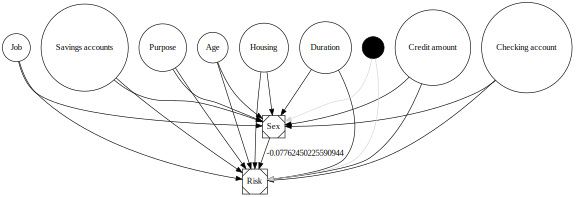

In [13]:
analysis(data1, treatment, outcome, common_causes)

## 2. Causal Estimand - T: Age, O: Risk
### $\rightarrow$ Are older people preferred in risk rating because of high age?

In [14]:
data2 = data.copy()

33.0


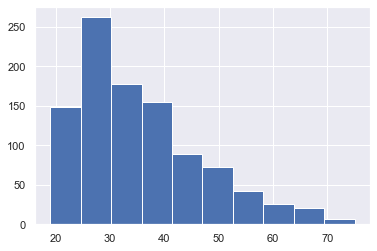

In [15]:
plt.hist(data2['Age'])
print(data2['Age'].median())

In [16]:
for i in range(len(data2.index)):
    if data2['Age'][i] > 33:
        data2['Age'][i] = True
    else:
        data2['Age'][i] = False
data2 = data2.astype({'Age':'bool'}, copy = False)
data2 = data2.dropna(axis=0)

In [17]:
# Set Treatment | Confounding Features | Outcome
treatment = 'Age'
outcome = 'Risk'
common_causes = 'Sex+Job+Housing+Savings accounts+Checking account+Credit amount+Duration+Purpose'.split('+')

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Age'] on outcome ['Risk']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Housing', 'Duration', 'Savings accounts', 'Purpose', 'Credit amount', 'Checking account', 'Job', 'Sex']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: Risk~Age+Housing+Duration+Purpose+Credit amount+Checking account+Job+Sex
ATE of Treatment 'Age' on Outcome 'Risk'     |     0.08207914661861138


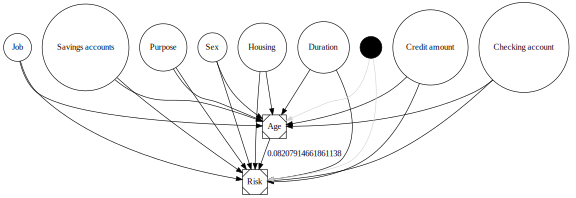

In [18]:
analysis(data2, treatment, outcome, common_causes)